In [1]:
!pip install scikit-learn matplotlib seaborn --quiet


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc


from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier


import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('student_education_dataset.csv')

print("Data loaded successfully ✅")
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

Data loaded successfully ✅
Shape: (1000, 10)
Columns: ['StudentID', 'AcademicScore', 'CourseParticipation', 'AttendanceRate', 'PhysicalActivity', 'EmotionEngagement', 'LearningStyle', 'DeviceUsage', 'FeedbackScore', 'StudentPerformance']


In [3]:
TARGET = 'StudentPerformance'

In [4]:
df = df.drop(columns=['StudentID'], errors='ignore')

In [5]:
df.fillna(df.median(numeric_only=True), inplace=True)

In [6]:
cat_cols = df.select_dtypes(include=['object']).columns
le = LabelEncoder()
for c in cat_cols:
    df[c] = le.fit_transform(df[c].astype(str))

In [7]:
X = df.drop(columns=[TARGET])
y = df[TARGET]

In [8]:
if y.dtype == 'object' or y.dtype.name == 'category':
    y = LabelEncoder().fit_transform(y)

In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [10]:
selector = SelectKBest(score_func=f_classif, k=min(8, X.shape[1]))
X_selected = selector.fit_transform(X_scaled, y)
selected_features = X.columns[selector.get_support()].tolist()
print("\nTop Selected Features:", selected_features)


Top Selected Features: ['AcademicScore', 'CourseParticipation', 'AttendanceRate', 'PhysicalActivity', 'EmotionEngagement', 'LearningStyle', 'DeviceUsage', 'FeedbackScore']


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)

In [12]:
models = {
'LogisticRegression': LogisticRegression(max_iter=1000),
'SVM': SVC(probability=True, kernel='rbf', C=1),
'KNN': KNeighborsClassifier(n_neighbors=5)
}


results = {}

In [13]:

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    results[name] = {'acc': acc, 'cm': cm, 'model': model}
    print(f"\n{name} Accuracy: {acc*100:.2f}%")
    print(classification_report(y_test, y_pred))


LogisticRegression Accuracy: 98.50%
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        39
           1       0.98      0.99      0.98        80
           2       1.00      0.99      0.99        81

    accuracy                           0.98       200
   macro avg       0.98      0.98      0.98       200
weighted avg       0.99      0.98      0.99       200


SVM Accuracy: 95.00%
              precision    recall  f1-score   support

           0       0.93      0.95      0.94        39
           1       0.94      0.94      0.94        80
           2       0.97      0.96      0.97        81

    accuracy                           0.95       200
   macro avg       0.95      0.95      0.95       200
weighted avg       0.95      0.95      0.95       200


KNN Accuracy: 82.50%
              precision    recall  f1-score   support

           0       0.79      0.69      0.74        39
           1       0.74      0.86      0.80     

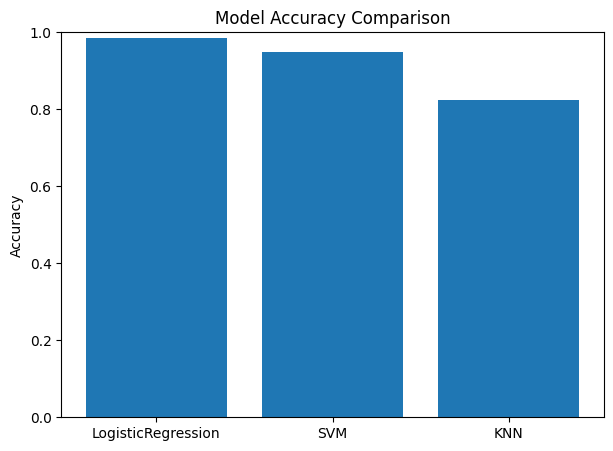

In [14]:
plt.figure(figsize=(7,5))
plt.bar(results.keys(), [v['acc'] for v in results.values()])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.show()

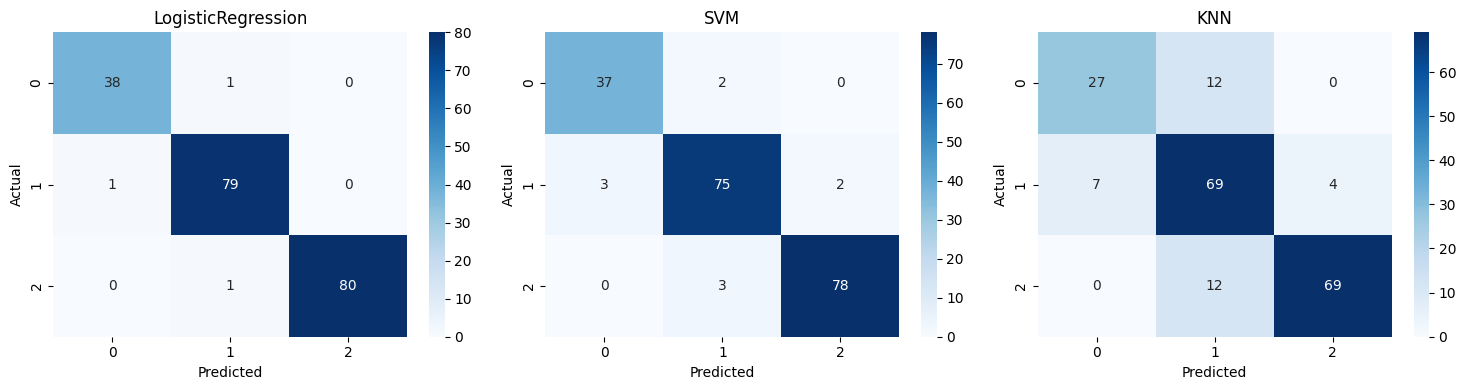

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(15,4))
for i, (name, res) in enumerate(results.items()):
    sns.heatmap(res['cm'], annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(name)
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')
plt.tight_layout()
plt.show()

In [16]:
if len(np.unique(y)) == 2:
    plt.figure(figsize=(6,5))
    for name, res in results.items():
        model = res['model']
        y_prob = model.predict_proba(X_test)[:,1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC={roc_auc:.2f})')
    plt.plot([0,1],[0,1],'k--')
    plt.title('ROC Curves Comparison')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

In [18]:
best_model = max(results.items(), key=lambda x: x[1]['acc'])
print(f"\n✅ Best Model: {best_model[0]} with Accuracy: {best_model[1]['acc']*100:.2f}%")
print("\nTip: Aim for 80–90% accuracy. If results are lower, consider:")
print("- Increasing features (interaction terms, encoding)\n- Balancing target classes\n- Tuning hyperparameters\n- Trying tree-based models like XGBoost or CatBoost")


✅ Best Model: LogisticRegression with Accuracy: 98.50%

Tip: Aim for 80–90% accuracy. If results are lower, consider:
- Increasing features (interaction terms, encoding)
- Balancing target classes
- Tuning hyperparameters
- Trying tree-based models like XGBoost or CatBoost
